In [5]:
#Importamos drive a colab porque es donde tenemos la mezcla de datasets que
#vamos a ulizar
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf

print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2.5.0


In [7]:
# Para copiar el .zip desde drive a colab
!cp /content/drive/My\ Drive/PruebaDataset.zip ../content/PruebaDataset.zip

# Para descomprimir el .zip
!unzip PruebaDataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: W/W1952.jpg             
  inflating: W/W1953.jpg             
  inflating: W/W1954.jpg             
  inflating: W/W1955.jpg             
  inflating: W/W1956.jpg             
  inflating: W/W1957.jpg             
  inflating: W/W1958.jpg             
  inflating: W/W1959.jpg             
  inflating: W/W196.jpg              
  inflating: W/W1960.jpg             
  inflating: W/W1961.jpg             
  inflating: W/W1962.jpg             
  inflating: W/W1963.jpg             
  inflating: W/W1964.jpg             
  inflating: W/W1965.jpg             
  inflating: W/W1966.jpg             
  inflating: W/W1967.jpg             
  inflating: W/W1968.jpg             
  inflating: W/W1969.jpg             
  inflating: W/W197.jpg              
  inflating: W/W1970.jpg             
  inflating: W/W1971.jpg             
  inflating: W/W1972.jpg             
  inflating: W/W1973.jpg             
  inflating: W/W1974.jpg   

<class 'PIL.JpegImagePlugin.JpegImageFile'>


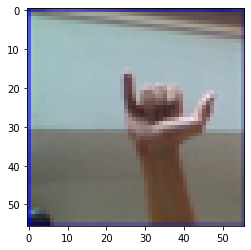

In [8]:
#Visualizamos una de las imagenes dentro del dataset
from PIL import Image
k=2
pic = Image.open("//content/Y/Y999.jpg") 
pix = np.array(pic)
print(type(pic))

plt.imshow(pic.resize((28*k,28*k)))

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

#Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        '/content',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        '/content',
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        subset = 'validation',
        batch_size=bs)

Found 35607 images belonging to 23 classes.
Found 8893 images belonging to 23 classes.


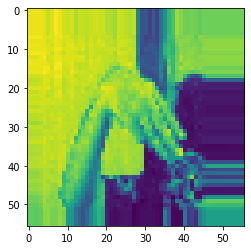

In [10]:
#Printeado de imagenes
plt.imshow(next(train_generator)[0][2,...,0])
plt.show()

In [11]:
#Para saber a qué clase se le asocia a cada letra
print(train_generator.class_indices)

{'.config': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'R': 15, 'T': 16, 'U': 17, 'V': 18, 'W': 19, 'Y': 20, 'drive': 21, 'sample_data': 22}


In [13]:
#Visualizamos el modelo que vamos a utilizar para el entrenamiento
import tensorflow as tf    
model = tf.keras.applications.VGG19()
model.summary()

574717952/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [15]:
##DEFINIMOS EL MODELO
from tensorflow.keras import regularizers
num_classes = 23
epochs = 25

# VGG19
# Importamos el modelo que queremos utilizar.
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos las 6 primeras capas del modelo que no seran reentrenadas
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [16]:
## EJECUCION DEL MODELO

model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.01),
              metrics=['accuracy'])

#Agregamos los callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
                               monitor = 'val_acc', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)
#Procedemos a entrenar
history= model.fit_generator(train_generator,
                             validation_data = valid_generator, 
                             callbacks=[reduce_lr, checkpointer], 
                             epochs=epochs)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
557/557 [==============================] - 156s 221ms/step - loss: 2.3404 - accuracy: 0.5927 - val_loss: 2.0657 - val_accuracy: 0.6598
Epoch 2/25
557/557 [==============================] - 113s 202ms/step - loss: 1.1055 - accuracy: 0.9136 - val_loss: 1.4461 - val_accuracy: 0.7924
Epoch 3/25
557/557 [==============================] - 111s 199ms/step - loss: 0.8275 - accuracy: 0.9484 - val_loss: 1.4569 - val_accuracy: 0.7753
Epoch 4/25
557/557 [==============================] - 111s 200ms/step - loss: 0.6591 - accuracy: 0.9617 - val_loss: 1.4216 - val_accuracy: 0.7828
Epoch 5/25
557/557 [==============================] - 111s 200ms/step - loss: 0.5198 - accuracy: 0.9712 - val_loss: 0.9238 - val_accuracy: 0.8540
Epoch 6/25
557/557 [==============================] - 111s 199ms/step - loss: 0.4281 - accuracy: 0.9739 - val_loss: 0.8899 - val_accuracy: 0.8531
Epoch 7/25
557/557 [==============================] - 111s 199ms/step - loss: 0.3489 - accuracy: 0.9780 - val_loss: 0.9439 -

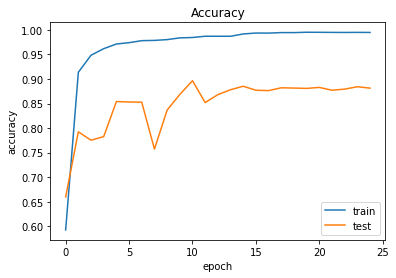

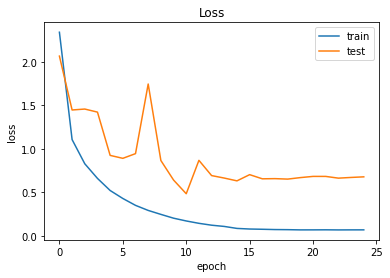

In [17]:
#Grafico para la precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

#Grafico para la perdiada
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [ ]:
#guardar modelo
model.save('path_to_my_model.h5')

# Nueva sección

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model = keras.models.load_model('path_to_my_model.h5')

In [ ]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path) #save your model 

# to reload your model 
model = keras.models.load_model(saved_model_path)